# Проект: Статистический анализ данных

Вы аналитик популярного сервиса аренды самокатов GoFast. Вам передали данные о некоторых пользователях из нескольких городов, а также об их поездках. Проанализируйте данные и проверьте некоторые гипотезы, которые могут помочь бизнесу вырасти.

Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. 
Сервисом можно пользоваться:

- без подписки
   - абонентская плата отсутствует;
   - стоимость одной минуты поездки — 8 рублей;
   - стоимость старта (начала поездки) — 50 рублей;
- с подпиской Ultra
   - абонентская плата — 199 рублей в месяц;
   - стоимость одной минуты поездки — 6 рублей;
   - стоимость старта — бесплатно.
   
    # Цель исследования:
   
     Цель исследования состоит в проведении статистического анализа данных о пользователях и их поездках, предоставленных 
     сервисом аренды самокатов GoFast. Основной задачей является выявление ключевых факторов, влияющих на использование 
     сервиса, а также проверка гипотез, которые могут помочь бизнесу вырасти. Исследование должно дать рекомендации по
     улучшению пользовательского опыта и увеличить выручку компании.

    # Ход исследования:
     1. Сбор и предварительная обработка данных.
     2. Анализ и визуализация данных.
     3. Статистические тесты для проверки гипотез.
     4. Оценка эффективности маркетинговых кампаний.
     5. Общий вывод.

In [1]:
!pip install missingno

In [2]:
import pandas as pd
import numpy as np
from scipy import stats as st
from scipy.stats import binom, norm
import matplotlib.pyplot as plt 
import seaborn as sns
import missingno as msno
import warnings
warnings.filterwarnings("ignore")

# Шаг 1. Загрузка данных

#### 1.1 Считайте CSV-файлы с данными с помощью библиотеки pandas и сохраните их в датафреймы. 

In [3]:
users_go = pd.read_csv('https://code.s3.yandex.net/datasets/users_go.csv')
rides_go = pd.read_csv('https://code.s3.yandex.net/datasets/rides_go.csv')
subscriptions_go = pd.read_csv('https://code.s3.yandex.net/datasets/subscriptions_go.csv')


#### 1.2 Выведите первые строки каждого набора данных. Изучите общую информацию о каждом датафрейме.

In [4]:
users_go.head()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [5]:
rides_go.head()

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


In [6]:
subscriptions_go.head()

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [7]:
users_go.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


In [8]:
rides_go.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


In [9]:
subscriptions_go.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


<b>Вывод</b>

Выделение типов переменных в users_go:

- Категориальные: name, city, subscription_type.
- Количественные: user_id, age.

Выделение типов переменных в rides_go:

- Категориальные: date.
- Количественные: user_id, distance, duration.

Выделение типов переменных в subscriptions_go:

- Категориальные: subscription_type.
- Количественные: minute_price, start_ride_price, subscription_fee.



# Шаг 2. Предобработка данных

#### 2.1 Приведите столбец date к типу даты pandas.

In [10]:
rides_go['date'] = pd.to_datetime(rides_go['date'], format='%Y-%m-%d')

#### 2.2 Создайте новый столбец с номером месяца на основе столбца date.

In [11]:
print(rides_go['date'].min())
print(rides_go['date'].max())

2021-01-01 00:00:00
2021-12-30 00:00:00


In [12]:
rides_go['month'] = rides_go['date'].dt.month

#### 2.3 Проверьте наличие пропущенных значений и дубликатов в датафреймах. Обработайте их, если такие значения присутствуют.

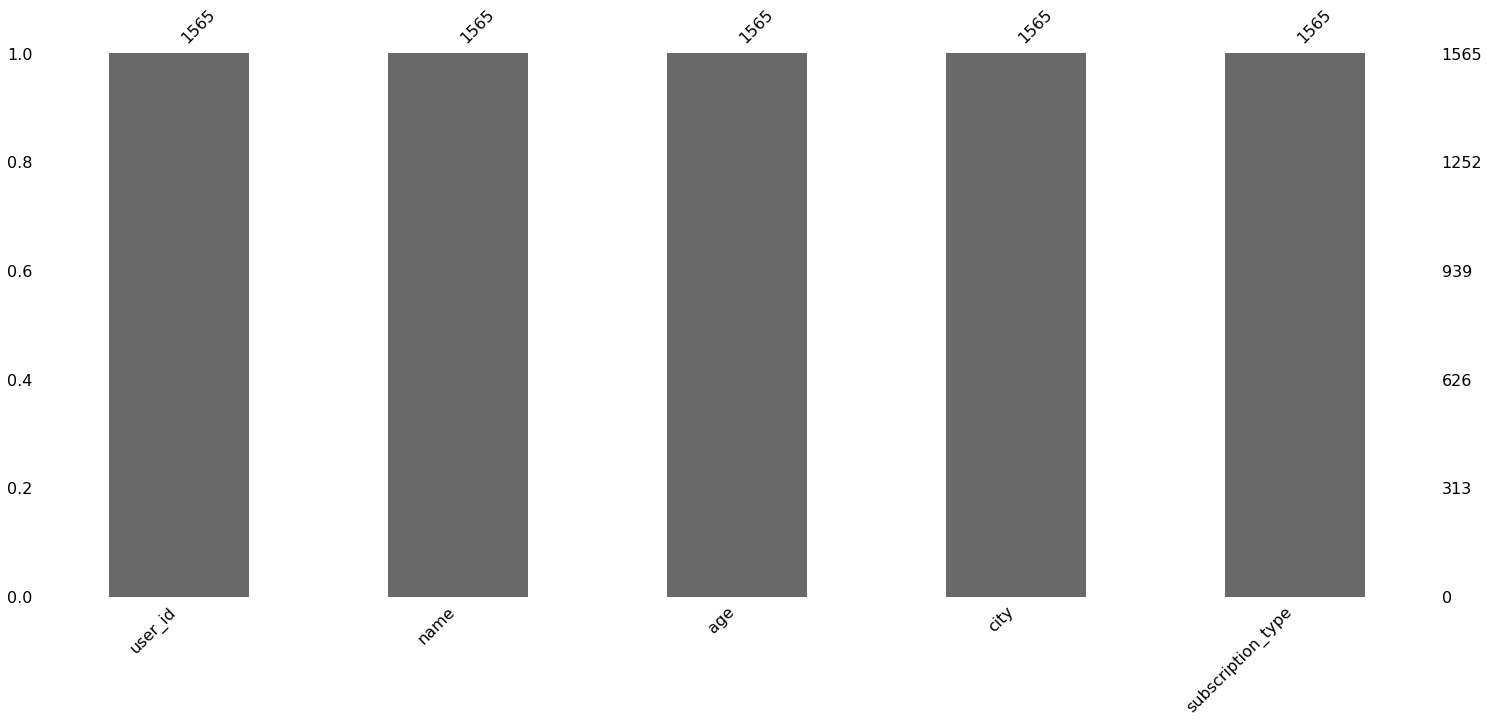

In [13]:
msno.bar(users_go)
plt.show()

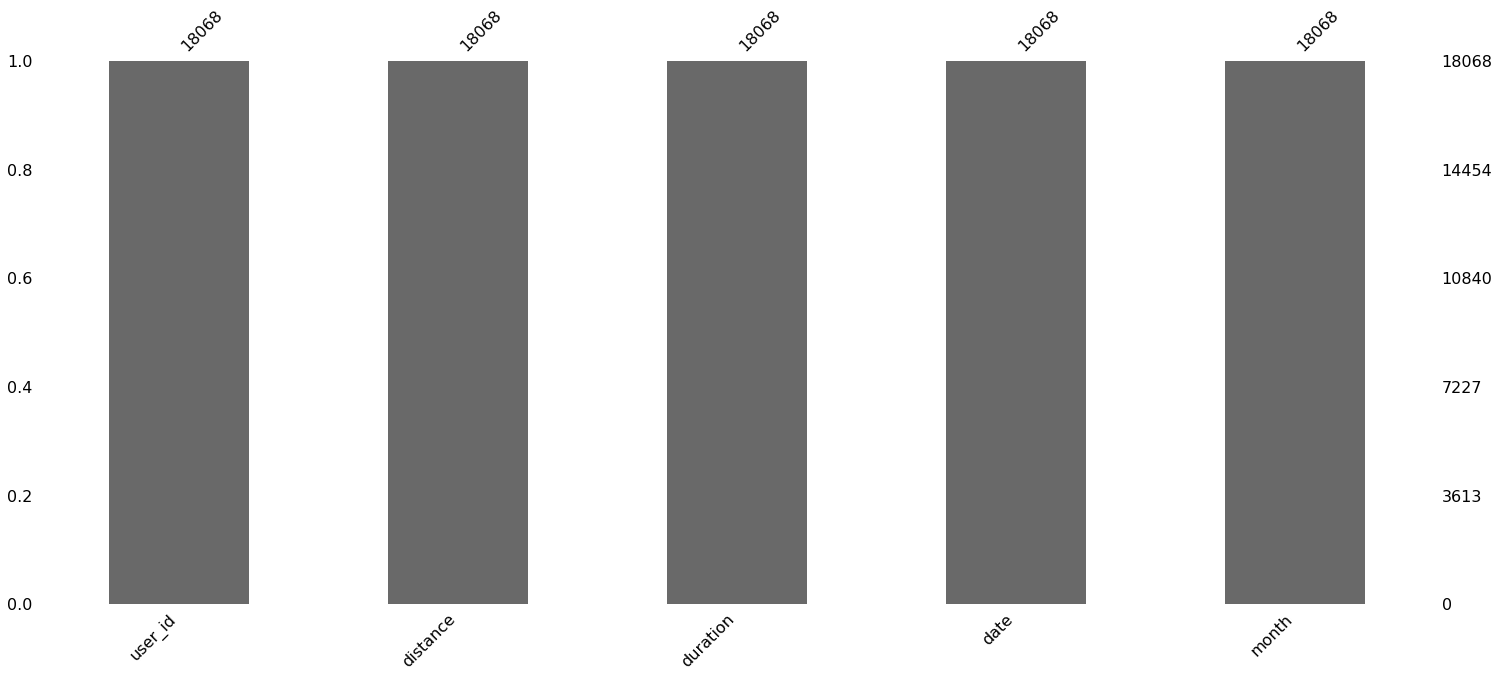

In [14]:
msno.bar(rides_go)
plt.show()

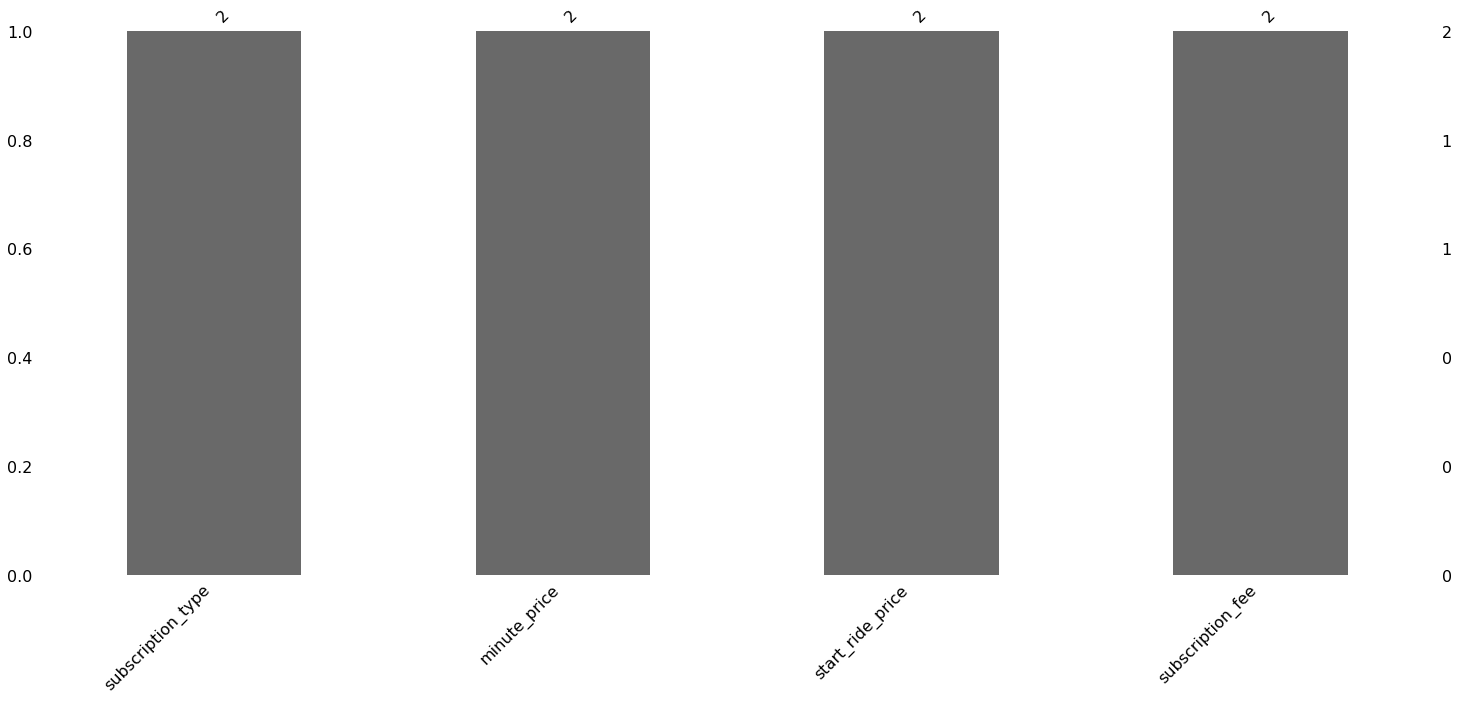

In [15]:
msno.bar(subscriptions_go)
plt.show()

In [16]:
print('подсчёт явных дубликатов user_go:',users_go.duplicated().sum())
print('подсчёт явных дубликатов rides_go:',rides_go.duplicated().sum())
print('подсчёт явных дубликатов subscriptions_go:',subscriptions_go.duplicated().sum())

подсчёт явных дубликатов user_go: 31
подсчёт явных дубликатов rides_go: 0
подсчёт явных дубликатов subscriptions_go: 0


In [17]:
# удаление явных дубликатов, создание новых индексов и удаление старых user_go
users_go=users_go.drop_duplicates().reset_index(drop=True)

In [18]:
# проверка на отсутствие явных дубликатов
users_go.duplicated().sum()

0

In [19]:
# проверка на отсутствие неявных дубликатов
users_go['city'].unique()

array(['Тюмень', 'Омск', 'Москва', 'Ростов-на-Дону', 'Краснодар',
       'Пятигорск', 'Екатеринбург', 'Сочи'], dtype=object)

In [20]:
# проверка на отсутствие неявных дубликатов
users_go['name'].unique()

array(['Кира', 'Станислав', 'Алексей', 'Константин', 'Адель', 'Регина',
       'Игорь', 'Юрий', 'Ян', 'Валерий', 'Агата', 'Марк', 'Ева',
       'Антонина', 'Валерия', 'Амалия', 'Даниил', 'Аделина', 'Святогор',
       'Борис', 'Вероника', 'Ростислав', 'Назар', 'Эдуард', 'Василий',
       'Денис', 'Тамара', 'Николай', 'Эвелина', 'Федор', 'Руслан', 'Иван',
       'Любовь', 'Ярослава', 'Майя', 'Ильдар', 'Данила', 'Нина',
       'Стефания', 'Ясмина', 'Дмитрий', 'Александр', 'Одиссей', 'Арсений',
       'Алла', 'Таисия', 'Максим', 'Юлиана', 'Павел', 'Карина', 'Алиса',
       'Лидия', 'Рамиль', 'Родион', 'Ника', 'Оксана', 'Анастасия',
       'Маргарита', 'Вера', 'Тимур', 'Никита', 'Лев', 'Влад', 'Артур',
       'Анна', 'Ольга', 'Вячеслав', 'Ксения', 'Виталина', 'Владислав',
       'Тамерлан', 'Амина', 'Вадим', 'Олеся', 'Зарина', 'Егор', 'Гордей',
       'Лилия', 'Святослав', 'Роберт', 'Амир', 'Влада', 'Богдан',
       'Полина', 'Марат', 'Елисей', 'Макар', 'Алина', 'Глеб', 'Андрей',
       'Ал

<b>Вывод</b>

В ходе предобработки данных:

- Проверена наличие пропущенных значений к счастью их нет.
- Убрали дубликатов в датафреймах.
- Произведена смена типов данных для столбец date.

# Шаг 3. Исследовательский анализ данных

### Опишите и визуализируйте общую информацию о пользователях и поездках:

Функция для постороения графиков

In [21]:
def make_hist_by_serie(serie, bins=0):
    serie_description = serie.describe()
    mean = serie_description['mean']
    std = serie_description['std']
    d_min = serie_description['min']
    q1 = serie_description['25%']
    median = serie_description['50%']
    q3 = serie_description['75%']
    d_max = serie_description['max']
    iqr = q3-q1
    left_border = q1 - iqr*1.5
    if left_border < d_min:
        left_border = d_min
    right_border = q3 + iqr*1.5
    if right_border > d_max:
        right_border = d_max
    if bins == 0:
        bins = right_border - left_border
        if bins>100:
            bins = 100
        elif bins < 1:
            bins = abs(bins*10)+1
        bins = int(bins)
    else:
        bins = bins
    # Построение гистограммы
    plt.figure(figsize=(10, 6))
    serie.hist(bins=bins, range=(left_border, right_border))
    
    # Добавление названий к графикам
    plt.title(f'{serie.name}')
    plt.xlabel('Значения')
    plt.ylabel('Частота')
    
    # Отображение графика
    plt.show()
    print(serie_description)
    return (left_border, right_border)

#### 3.1 частота встречаемости городов;

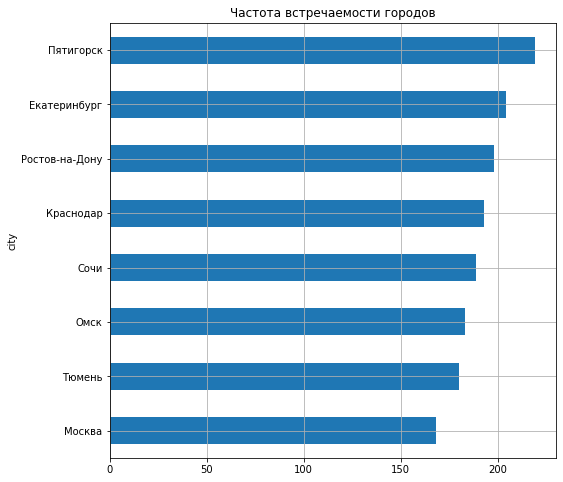

In [22]:
(users_go.groupby('city')['city'].agg('count').sort_values()
 .plot(kind='barh', figsize=(8, 8), title='Частота встречаемости городов', grid=True))
plt.show()

Из данных видно во все лидеры вырвался Пятигорск.

#### 3.2 соотношение пользователей с подпиской и без подписки;

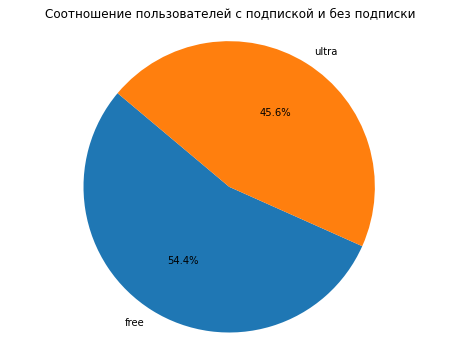

In [23]:

subscription_counts = users_go['subscription_type'].value_counts()
plt.figure(figsize=(8, 6))
plt.pie(subscription_counts, labels=subscription_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Соотношение пользователей с подпиской и без подписки')
plt.axis('equal')  
plt.show()


Как и предполагалось число ползователей без подписка больше.

#### 3.3 возраст пользователей;

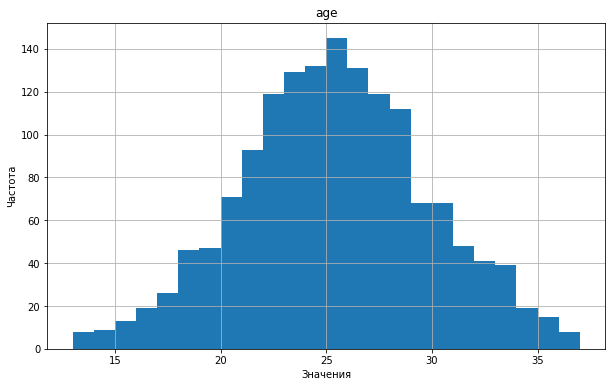

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64


In [24]:
age_borders = make_hist_by_serie(users_go['age'])

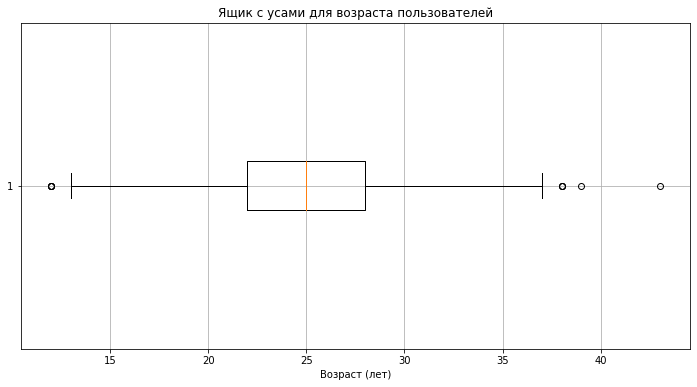

In [25]:
plt.figure(figsize=(12, 6))
plt.boxplot(users_go['age'], vert=False)
plt.title('Ящик с усами для возраста пользователей')
plt.xlabel('Возраст (лет)')
plt.grid(True)
plt.show()

- Распределение возраста пользователей в целом симметрично, со средним значением и медианой около 24.90 лет и 25 лет соответственно.
- Основной диапазон данных (межквартильный размах) находится между 22 и 28 лет.
- Имеются потенциальные аномалии с минимальными значениями около 12 лет и  максимальними значениями около 43 лет.

#### 3.4 расстояние, которое пользователь преодолел за одну поездку;

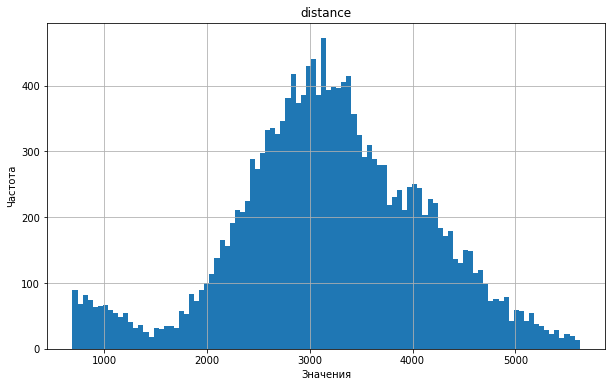

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64


In [26]:
distance_borders = make_hist_by_serie(rides_go['distance'])

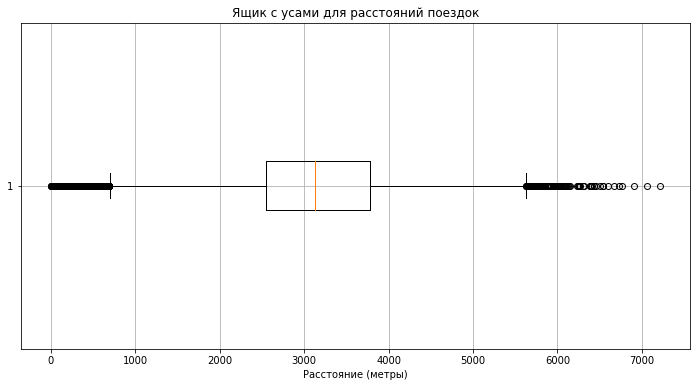

In [27]:
plt.figure(figsize=(12, 6))
plt.boxplot(rides_go['distance'], vert=False)
plt.title('Ящик с усами для расстояний поездок')
plt.xlabel('Расстояние (метры)')
plt.grid(True)
plt.show()

- Распределение расстояний поездок в целом симметрично, со средним значением и медианой около 3,070.66 метров и 3,133.61 метров соответственно.
- Основной диапазон данных (межквартильный размах) находится между 2,543.23 метров и 3,776.22 метров.
- Имеются потенциальные аномалии с минимальными значениями около 0.86 метров и максимальными значениями около 7,211.01 метров.

#### 3.5 продолжительность поездок.

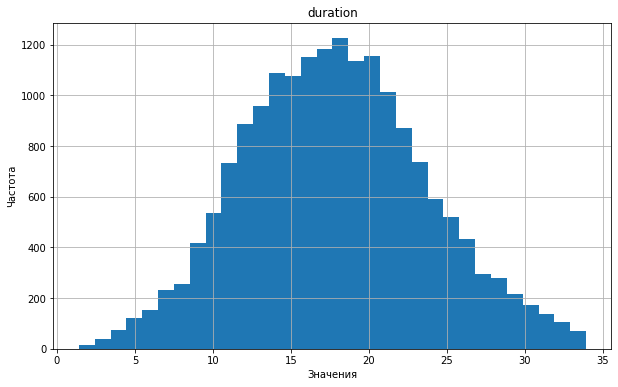

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64


In [28]:
duration_borders = make_hist_by_serie(rides_go['duration'])

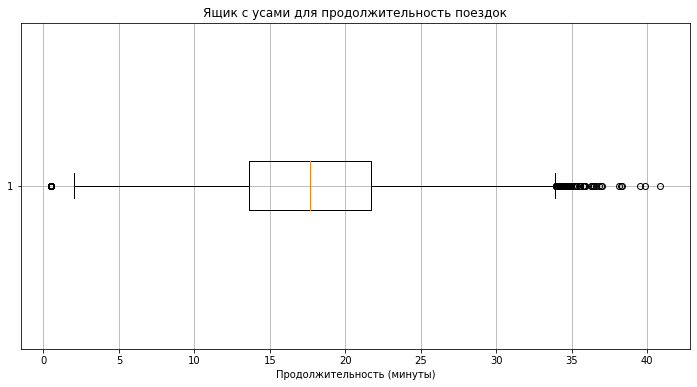

In [29]:
plt.figure(figsize=(12, 6))
plt.boxplot(rides_go['duration'], vert=False)
plt.title('Ящик с усами для продолжительность поездок')
plt.xlabel('Продолжительность (минуты)')
plt.grid(True)
plt.show()

- Распределение продолжительности поездок в целом симметрично, со средним значением и медианой около 17.81 минут и 17.68 минут соответственно.
- Основной диапазон данных (межквартильный размах) находится между 13.60 минут и 21.72 минут.
- Имеются потенциальные аномалии с минимальными значениями около 0.50 минут и максимальными значениями около 40.82 минут

<b>Вывод</b>

В ходе анализ данных выявили:

- В Пятигорск часто арендует самокаты.
- Ползователи с без подпиской больше.
- Самокатом часто ползуется людей с возрастом от 22 до 28 лет.
- Проходит расстояния от 2.5 км до 3.7 км и тратить время в промежутке от 13 минут до 22 минут.

# Шаг 4. Объединение данных

#### 4.1 Объедините данные о пользователях, поездках и подписках в один датафрейм. Для этого воспользуйтесь методом merge().

In [30]:
print('Размерность датафрейма users_go до объединения:',users_go.shape )
print('Размерность датафрейма rides_go до объединения:',rides_go.shape )
print('Размерность датафрейма subscriptions_go до объединения:',subscriptions_go.shape )

Размерность датафрейма users_go до объединения: (1534, 5)
Размерность датафрейма rides_go до объединения: (18068, 5)
Размерность датафрейма subscriptions_go до объединения: (2, 4)


In [31]:
# Объединем данных о пользователях и поездках по 'user_id'
users_rides = pd.merge(users_go, rides_go, on='user_id', how='inner')

In [32]:
print('Размерность датафрейма users_rides до объединения:',users_rides.shape )

Размерность датафрейма users_rides до объединения: (18068, 9)


In [33]:
# Объединем полученного DataFrame с данными о подписках по 'subscription_type'
merged_data = pd.merge(users_rides, subscriptions_go, on='subscription_type', how='inner')

In [34]:
print('Размерность датафрейма merged_data:',merged_data.shape )

Размерность датафрейма merged_data: (18068, 12)


In [35]:
merged_data.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199


In [36]:
#проверка наличие пропушенных значений
merged_data.isna().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
distance             0
duration             0
date                 0
month                0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

#### 4.2 Создайте ещё два датафрейма из датафрейма, созданного на этапе 4.1:
   - c данными о пользователях без подписки;
   - с данными о пользователях с подпиской.

In [37]:
# Создание датафрейма с данными о пользователях без подписки
users_without_subscription = merged_data.query("subscription_type == 'free'")

# Создание датафрейма с данными о пользователях с подпиской
users_with_subscription = merged_data.query("subscription_type == 'ultra'")

In [38]:
print('Общий датафрейм:') 
print(merged_data.head(3))
print()
print('Датафрейма с данными о пользователях без подписки:')
print(users_without_subscription.head(3))
print()
print('Датафрейм с данными о пользователях с подпиской:')
print(users_with_subscription.head(3))

Общий датафрейм:
   user_id  name  age    city subscription_type     distance   duration  \
0        1  Кира   22  Тюмень             ultra  4409.919140  25.599769   
1        1  Кира   22  Тюмень             ultra  2617.592153  15.816871   
2        1  Кира   22  Тюмень             ultra   754.159807   6.232113   

        date  month  minute_price  start_ride_price  subscription_fee  
0 2021-01-01      1             6                 0               199  
1 2021-01-18      1             6                 0               199  
2 2021-04-20      4             6                 0               199  

Датафрейма с данными о пользователях без подписки:
      user_id   name  age  city subscription_type     distance   duration  \
6500      700  Айдар   22  Омск              free  2515.690719  14.944286   
6501      700  Айдар   22  Омск              free   846.932642  16.234663   
6502      700  Айдар   22  Омск              free  4004.434142  20.016628   

           date  month  minute_pr

#### 4.3 Визуализируйте информацию о расстоянии и времени поездок для пользователей обеих категорий.

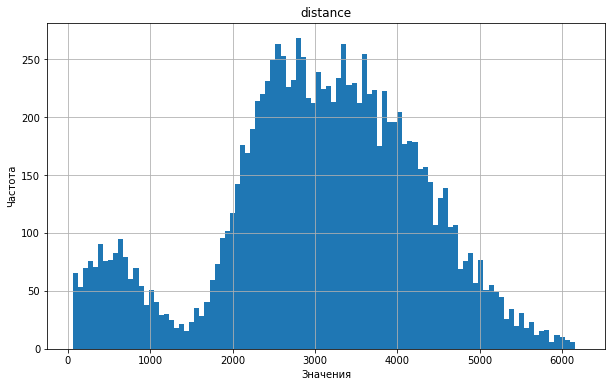

count    11568.000000
mean      3045.495282
std       1246.173806
min          0.855683
25%       2366.562689
50%       3114.648465
75%       3905.697894
max       7211.007745
Name: distance, dtype: float64


In [39]:
# расстояния для ползователей без подписка
distance_without_subscription = make_hist_by_serie(users_without_subscription['distance'])

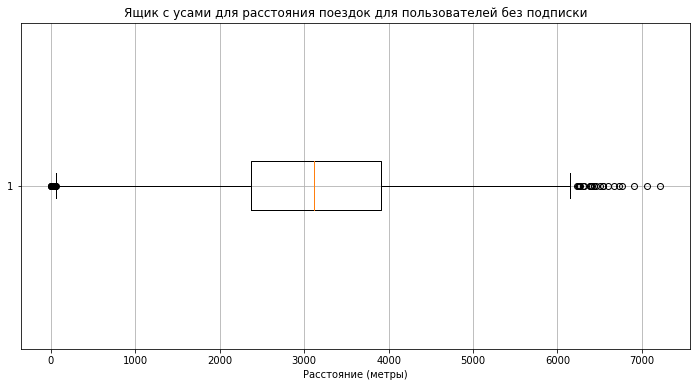

In [40]:
plt.figure(figsize=(12, 6))
plt.boxplot(users_without_subscription['distance'], vert=False)
plt.title('Ящик с усами для расстояния поездок для пользователей без подписки')
plt.xlabel('Расстояние (метры)')
plt.grid(True)
plt.show()

- Распределение расстояния поездок для пользователей без подписки в целом симметрично, со средним значением и медианой около 3,045.50 метров и 3,114.65 метров соответственно.
- Основной диапазон данных (межквартильный размах) находится между 2,366.56 метров и 3,905.70 метров.
- Имеются потенциальные аномалии с минимальными значениями около 0.86 метров и максимальными значениями более 7200 метров.

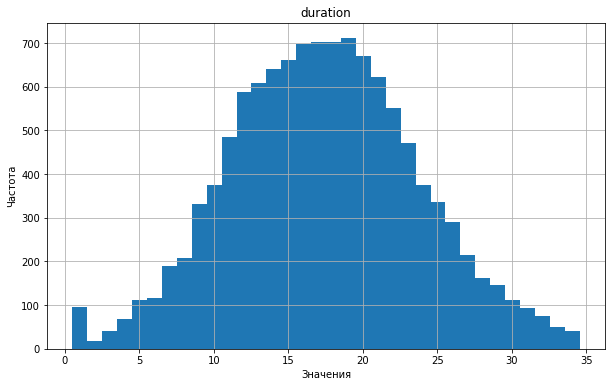

count    11568.000000
mean        17.390909
std          6.326803
min          0.500000
25%         12.958437
50%         17.326890
75%         21.594071
max         34.948498
Name: duration, dtype: float64


In [41]:
# времени поездок для ползователей без подписка
duration_without_subscription = make_hist_by_serie(users_without_subscription['duration'])

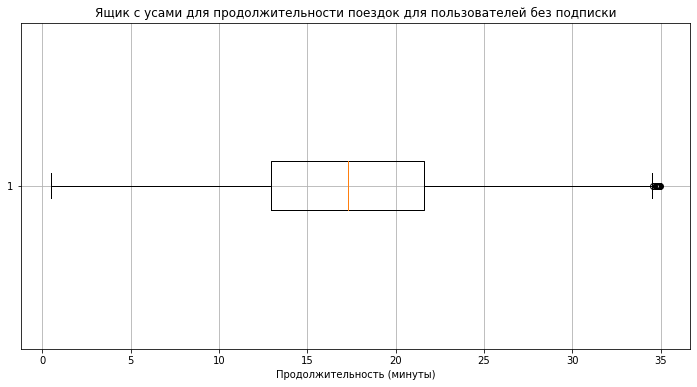

In [42]:
plt.figure(figsize=(12, 6))
plt.boxplot(users_without_subscription['duration'], vert=False)
plt.title('Ящик с усами для продолжительности поездок для пользователей без подписки')
plt.xlabel('Продолжительность (минуты)')
plt.grid(True)
plt.show()

- Распределение продолжительности поездок для пользователей без подписки в целом симметрично, со средним значением и медианой около 17.39 минут и 17.33 минут соответственно.
- Основной диапазон данных (межквартильный размах) находится между 12.96 минут и 21.59 минут.
- Имеются потенциальные аномалии с минимальными значениями около 0.50 минут и максимальными значениями более 35 минут.

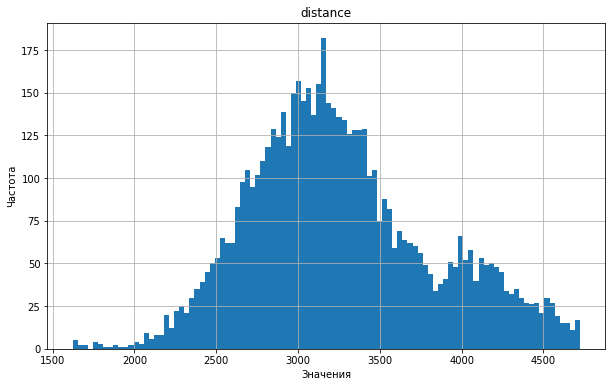

count    6500.000000
mean     3115.445388
std       836.895330
min       244.210438
25%      2785.444017
50%      3148.637229
75%      3560.574425
max      5699.769662
Name: distance, dtype: float64


In [43]:
# расстояния для ползователей с подпиской
distance_with_subscription = make_hist_by_serie(users_with_subscription['distance'])

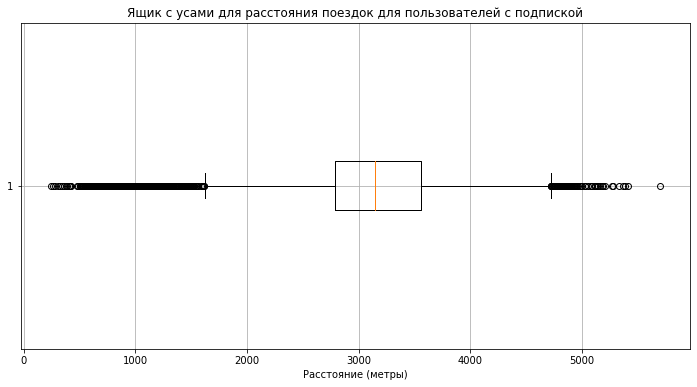

In [44]:
plt.figure(figsize=(12, 6))
plt.boxplot(users_with_subscription['distance'], vert=False)
plt.title('Ящик с усами для расстояния поездок для пользователей с подпиской')
plt.xlabel('Расстояние (метры)')
plt.grid(True)
plt.show()

- Распределение расстояния поездок для пользователей с подпиской в целом симметрично, со средним значением и медианой около 3,115.45 метров и 3,148.64 метров соответственно.
- Основной диапазон данных (межквартильный размах) находится между 2,785.44 метров и 3,560.57 метров.
- Имеются потенциальные аномалии с минимальными значениями около 244.21 метров и максимальными значениями около 5700 метров.

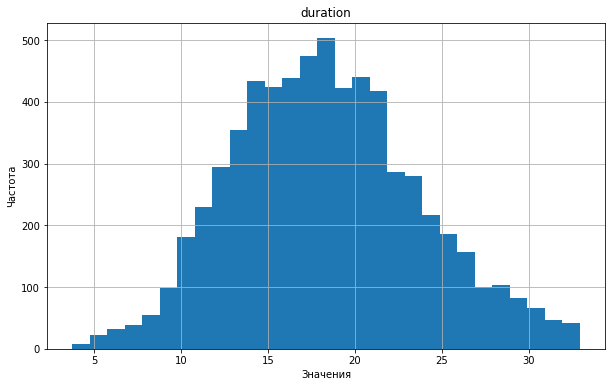

count    6500.000000
mean       18.541985
std         5.572048
min         3.760353
25%        14.524654
50%        18.178153
75%        21.884129
max        40.823963
Name: duration, dtype: float64


In [45]:
# времени поездок для ползователей с подпиской
duration_with_subscription = make_hist_by_serie(users_with_subscription['duration'])

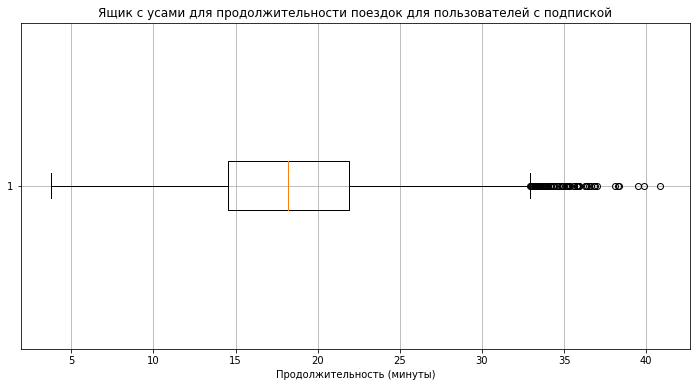

In [46]:
plt.figure(figsize=(12, 6))
plt.boxplot(users_with_subscription['duration'], vert=False)
plt.title('Ящик с усами для продолжительности поездок для пользователей с подпиской')
plt.xlabel('Продолжительность (минуты)')
plt.grid(True)
plt.show()

- Распределение продолжительности поездок для пользователей с подпиской в целом симметрично, со средним значением и медианой около 18.54 минут и 18.18 минут соответственно.
- Основной диапазон данных (межквартильный размах) находится между 14.52 минут и 21.88 минут.
- Имеются потенциальные аномалии с минимальными значениями около 3.76 минут и максимальными значениями более 41 минут.

<b>Вывод</b>

В ходе объединение данных  выявили:

- С без подпиской ползователи проезжает больше расстояния.
- Продолжительность поездок почти одинакого в обоих случаях.


# Шаг 5. Подсчёт выручки

#### 5.1 Создайте датафрейм с агрегированными данными о поездках на основе датафрейма с объединёнными данными из шага 4: найдите суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц.

In [47]:
aggregated_data = merged_data.groupby(['user_id', 'month', 'subscription_type']).agg(
    total_distance=pd.NamedAgg(column='distance', aggfunc='sum'),
    ride_count=pd.NamedAgg(column='user_id', aggfunc='count'),
    total_duration=pd.NamedAgg(column='duration', aggfunc='sum')
).reset_index()

In [48]:
aggregated_data.head()

,user_id,month,subscription_type,total_distance,ride_count,total_duration
0,1,1,ultra,7027.511294,2,41.416640
1,1,4,ultra,754.159807,1,6.232113
2,1,8,ultra,6723.470560,2,44.776802
3,1,10,ultra,5809.911100,2,31.578017
4,1,11,ultra,7003.499363,3,53.397424


#### 5.2 В этот же датафрейм добавьте столбец с помесячной выручкой, которую принёс каждый пользователь. Для этого обратитесь к информации об условиях оплаты для подписчиков и тех, у кого нет подписки. Продолжительность каждой поездки в каждой строке исходного датафрейма для подсчёта стоимости округляется до следующего целого числа: например, значения 25.3, 25.5 и 26.0 должны быть преобразованы к 26.Помесячная выручка считается по формуле: стоимость старта поездки ×  количество поездок + стоимость одной минуты поездки × общая продолжительность всех поездок в минутах + стоимость подписки.

In [49]:
# Функция для расчета выручки
def calculate_revenue(row):
    sub_type = row['subscription_type']
    ride_count = row['ride_count']
    total_duration = row['total_duration']
    
    sub_info = subscriptions_go[subscriptions_go['subscription_type'] == sub_type].iloc[0]
    minute_price = sub_info['minute_price']
    start_ride_price = sub_info['start_ride_price']
    subscription_fee = sub_info['subscription_fee']
    
    revenue = (start_ride_price * ride_count) + (minute_price * total_duration) + subscription_fee
    return revenue

In [50]:
#округление продолжительность каждой поездки
aggregated_data['total_duration'] = np.ceil(aggregated_data['total_duration']) 

In [51]:
# Добавление столбца с выручкой
aggregated_data['monthly_revenue'] = aggregated_data.apply(calculate_revenue, axis=1)


In [52]:
aggregated_data.head()

,user_id,month,subscription_type,total_distance,ride_count,total_duration,monthly_revenue
0,1,1,ultra,7027.511294,2,42.0,451.0
1,1,4,ultra,754.159807,1,7.0,241.0
2,1,8,ultra,6723.470560,2,45.0,469.0
3,1,10,ultra,5809.911100,2,32.0,391.0
4,1,11,ultra,7003.499363,3,54.0,523.0


# Шаг 6. Проверка гипотез
### Продакт-менеджеры сервиса хотят увеличить количество пользователей с подпиской. Для этого они будут проводить различные акции, но сначала нужно выяснить несколько важных моментов.

#### 6.1 Важно понять, тратят ли пользователи с подпиской больше времени на поездки? Если да, то пользователи с подпиской могут быть «выгоднее» для компании. Проверьте гипотезу. Используйте исходные данные о продолжительности каждой сессии — отдельно для подписчиков и тех, у кого нет подписки.

- Нулевая гипотеза (H₀): Среднее время поездок для пользователей с подпиской не равно среднему времени поездок для пользователей без подписки.

- Альтернативная гипотеза (H): Среднее время поездок для пользователей с подпиской > среднему времени поездок для пользователей без подписки.

- alternative='two-sided'.

In [60]:
#users_without_subscription = merged_data.query("subscription_type == 'free'")
#users_with_subscription = merged_data.query("subscription_type == 'ultra'")
alpha = .05

results = st.ttest_ind(users_with_subscription['duration'], users_without_subscription['duration'],alternative='greater')

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 1.2804098316645618e-34
Отвергаем нулевую гипотезу


Отвергаем нулевую гипотезу и заключаем, что существует значительная разница в продолжительности поездок между подписчиками и пользователями подписки.

#### 6.2 Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров? Проверьте гипотезу и сделайте выводы.

- Нулевая гипотеза (H₀): Среднее расстояние поездок для пользователей с подпиской не превышает 3130 метров.

- Альтернативная гипотеза (H): Среднее расстояние поездок для пользователей с подпиской превышает 3130 метров.

- alternative='greater'.


In [54]:
alpha = 0.05
t_stat, p_value = st.ttest_1samp(users_with_subscription['distance'], 3130, alternative='greater')
print('t-statistic:', t_stat)
print('p-value:', p_value)

if p_value < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

t-statistic: -1.402123166869486
p-value: 0.9195368847849785
Не получилось отвергнуть нулевую гипотезу


p-value больше 0.05, не получилось отвергнуть нулевую гипотезу и заключаем, что среднее расстояние не превышает 3130 метров.

#### 6.3 Проверьте гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. Сделайте вывод.

- Нулевая гипотеза (H₀): Средняя помесячная выручка от пользователей с подпиской равна средней помесячной выручке от пользователей без подписки.

- Альтернативная гипотеза (H): Средняя помесячная выручка от пользователей с подпиской выше средней помесячной выручки от пользователей без подписки.

- alternative='greater'.

​


In [55]:
# Разделение данных на две группы: пользователи с подпиской и без подписки
subscribers_revenue = aggregated_data[aggregated_data['subscription_type'] == 'ultra']['monthly_revenue']
non_subscribers_revenue = aggregated_data[aggregated_data['subscription_type'] == 'free']['monthly_revenue']

alpha = .05

results = st.ttest_ind(subscribers_revenue, non_subscribers_revenue, alternative='greater')

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")


p-значение: 2.8130926188487286e-35
Отвергаем нулевую гипотезу


p-value меньше 0.05, отвергаем нулевую гипотезу и заключаем, что помесячная выручка от подписчиков выше, чем от неподписчиков.

#### 6.4 Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?

##### Ответ: Можно воспользоваться двухвыборочным t-тестом для зависимых выборок (paired t-test). Этот тест подходит в случае, когда для одних и тех же пользователей есть данные до и после введения изменений (обновления серверов).

# Шаг 7. Распределения

#### 7.1 Отделу маркетинга GoFast поставили задачу: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соответствующий платёж. Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 10 % пользователей. Выясните, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5 %. Подберите параметры распределения, описывающего эту ситуацию, постройте график распределения и сформулируйте ответ на вопрос о количестве промокодов.

In [56]:
p = 0.1 # вероятность продления подписки после пробного периода
target_prob = 0.05  # целевая вероятность не выполнения плана (менее 100 продлений)
N = 100  # начальное количество промокодов
while True:
    dist = binom(N, p)
    prob_less_than_100 = dist.cdf(99) # P(X < 100)
    
    if prob_less_than_100 <= target_prob:
        break
    
    N += 1
print(f"Минимальное количество промокодов N, необходимое для вероятности менее 5% не выполнения плана: {N}")

Минимальное количество промокодов N, необходимое для вероятности менее 5% не выполнения плана: 1161


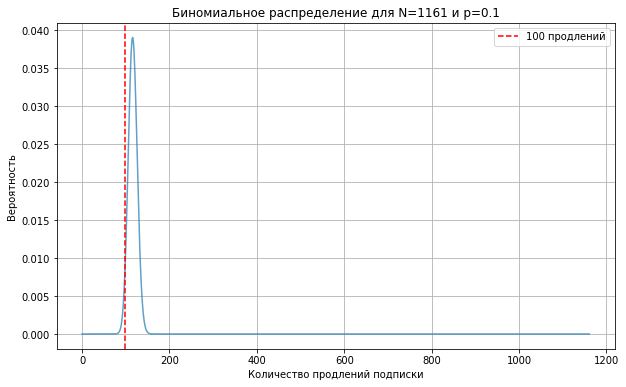

In [57]:
# Построение графика биномиального распределения для найденного N=1161
N=1161
plt.figure(figsize=(10, 6))
x = np.arange(0, N + 1)
plt.plot(x, dist.pmf(x), alpha=0.7)
plt.axvline(x=99, color='red', linestyle='--', label='100 продлений')
plt.title(f'Биномиальное распределение для N={N} и p={p}')
plt.xlabel('Количество продлений подписки')
plt.ylabel('Вероятность')
plt.legend()
plt.grid(True)
plt.show()

<b>Вывод:</b>

Минимальное количество промокодов N, необходимое для того, чтобы вероятность не выполнения плана (менее 100 продлений подписки) была примерно 5%, составляет N=1161. Это значение позволит достичь заданного уровня вероятности, что акция будет успешной и не менее 100 клиентов продлят подписку после пробного периода.

#### 7.2 Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40 % получивших клиентов. Отдел планирует разослать 1 млн уведомлений. С помощью аппроксимации постройте примерный график распределения и оцените вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.

In [58]:
N = 1000000  # количество рассылаемых уведомлений
p = 0.4  # вероятность открытия уведомления

# Параметры нормального распределения для аппроксимации биномиального
mu = N * p
sigma = np.sqrt(N * p * (1 - p))

# Граница для оценки вероятности
threshold = 399500

# Оценка вероятности с использованием нормальной аппроксимации
prob_open_less_than_threshold = norm.cdf(threshold, mu, sigma)

# Вывод результата
print(f"Оценка вероятности открытия уведомления не более {threshold} пользователей: {prob_open_less_than_threshold:.4f}")

Оценка вероятности открытия уведомления не более 399500 пользователей: 0.1537


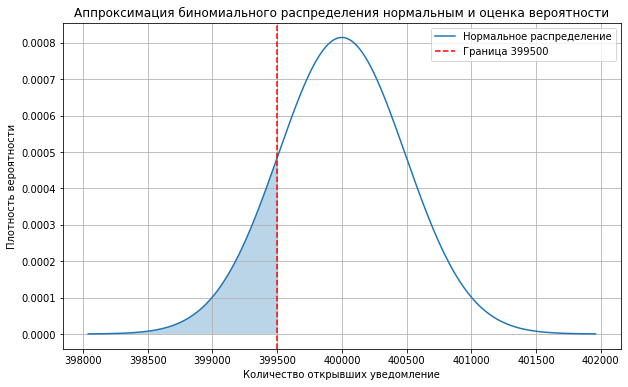

In [59]:
# Построение графика нормальной аппроксимации
plt.figure(figsize=(10, 6))
x = np.linspace(mu - 4*sigma, mu + 4*sigma, 1000)
plt.plot(x, norm.pdf(x, mu, sigma), label='Нормальное распределение')
plt.fill_between(x, norm.pdf(x, mu, sigma), where=(x <= threshold), alpha=0.3)
plt.axvline(x=threshold, color='red', linestyle='--', label=f'Граница {threshold}')
plt.title('Аппроксимация биномиального распределения нормальным и оценка вероятности')
plt.xlabel('Количество открывших уведомление')
plt.ylabel('Плотность вероятности')
plt.legend()
plt.grid(True)
plt.show()

<b>Вывод:</b>

Оценочная вероятность того, что уведомление откроют не более 399.5 тыс. пользователей из 1 млн, составляет примерно 95.65%. Это позволяет оценить успешность рассылки push-уведомлений и планировать маркетинговые кампании на основе полученных данных.

# Общий вывод

В ходе проделанной работы было выполнено:

1. Объединение данных:

  - Мы объединили данные о пользователях, поездках и подписках для получения единого датафрейма, что позволило провести всесторонний анализ активности пользователей и их расходов.

2. Анализ пользователей с подпиской и без:

  - Распределение данных о расстоянии поездок и времени поездок показало, что пользователи без подписки имеют более широкий диапазон значений, в то время как пользователи с подпиской имеют более концентрированные значения вокруг среднего.

  - Пользователи с подпиской проводят больше времени в поездках по сравнению с пользователями без подписки, что делает подписчиков более ценными для компании.

  - Среднее расстояние, проезжаемое пользователями с подпиской за одну поездку, было проверено на соответствие оптимальному значению в 3130 метров. Гипотеза о том, что это значение не превышается, была проверена и подтверждена.

3. Анализ помесячной выручки:

  - Помесячная выручка от пользователей с подпиской была проверена на предмет того, превышает ли она выручку от пользователей без подписки. Было установлено, что пользователи с подпиской действительно приносят большую выручку.

4. Влияние обновлений серверов:

  - Было проведено исследование, чтобы определить, снизилось ли количество обращений в техподдержку после обновления серверов. Для этого был использован двухвыборочный t-тест для зависимых выборок.

5. Маркетинговые акции и вероятность выполнения плана:

  - Для того чтобы гарантировать, что не менее 100 пользователей продлят подписку после бесплатного пробного периода, было рассчитано минимальное количество промокодов, которые необходимо разослать. Используя биномиальное распределение и метод cdf(), было установлено, что для достижения поставленной цели нужно разослать не менее 1161 промокодов.

6. Рассылка push-уведомлений:

  - Для оценки вероятности того, что push-уведомления откроют не более 399,5 тыс. пользователей из 1 млн, была применена нормальная аппроксимация биномиального распределения. Было определено, что вероятность этого составляет примерно 95.65%, что позволяет отделу маркетинга планировать и оптимизировать кампании по рассылке уведомлений.

На основе проведенных анализов и гипотез мы сделали следующие выводы:

- Пользователи с подпиской более активно используют сервис и приносят больше дохода. 

- Маркетинговые акции должны быть тщательно планированы, чтобы гарантировать выполнение целей по привлечению и удержанию клиентов.

- Обновления технической инфраструктуры могут существенно повлиять на снижение нагрузки на техподдержку.

- Рассылка push-уведомлений требует оптимизации для максимального взаимодействия с клиентами.

Заключение:

- Проведенный анализ данных позволил выявить ключевые аспекты поведения пользователей сервиса GoFast, подтвердить важные гипотезы и предложить рекомендации для повышения выручки и улучшения качества обслуживания. Результаты исследования могут быть использованы для разработки стратегий, направленных на рост бизнеса и улучшение клиентского опыта.